In [40]:
import warnings
warnings.filterwarnings('ignore')

In [41]:
#!pip install nltk sklearn wordcloud pymorphy2 stop_words

In [92]:
#!pip install pandas numpy matplotlib seaborn

In [145]:
!pip install sklearn

In [146]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import string
import pymorphy2
import seaborn as sns
from scipy.sparse import *
import stop_words
from nltk.stem.snowball import RussianStemmer
from nltk.tokenize import sent_tokenize, word_tokenize 
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
import json

%matplotlib inline

In [44]:
def log_progress(sequence, every=None, size=None, name='Items'):
    from ipywidgets import IntProgress, HTML, VBox
    from IPython.display import display

    is_iterator = False
    if size is None:
        try:
            size = len(sequence)
        except TypeError:
            is_iterator = True
    if size is not None:
        if every is None:
            if size <= 200:
                every = 1
            else:
                every = int(size / 200)     # every 0.5%
    else:
        assert every is not None, 'sequence is iterator, set every'

    if is_iterator:
        progress = IntProgress(min=0, max=1, value=1)
        progress.bar_style = 'info'
    else:
        progress = IntProgress(min=0, max=size, value=0)
    label = HTML()
    box = VBox(children=[label, progress])
    display(box)

    index = 0
    try:
        for index, record in enumerate(sequence, 1):
            if index == 1 or index % every == 0:
                if is_iterator:
                    label.value = '{name}: {index} / ?'.format(
                        name=name,
                        index=index
                    )
                else:
                    progress.value = index
                    label.value = u'{name}: {index} / {size}'.format(
                        name=name,
                        index=index,
                        size=size
                    )
            yield record
    except:
        progress.bar_style = 'danger'
        raise
    else:
        progress.bar_style = 'success'
        progress.value = index
        label.value = "{name}: {index}".format(
            name=name,
            index=str(index or '?')
        )

**Загружаем данные**

In [45]:
news = []
with open('corpus.json', 'r', encoding="utf-8") as file:
    text = file.read()
    dct = json.loads(text)
data = pd.DataFrame(dct['catalog'])
data.head()

,article_id,category,title,text,tags
0,https://www.nn.ru/text/auto/2022/01/12/70369148/,auto,Кризис ОСАГО залатали рублем. Полисы резко под...,ОСАГО сильно прибавило для неблагополучных вод...,"[ОСАГО, автозакон, страховка]"
1,https://www.nn.ru/text/auto/2022/01/11/70366607/,auto,Я пропустил техосмотр в 2021 году. Оштрафуют л...,Обязательный техосмотр для частных машин отмен...,"[автозакон, техосмотр, автоликбез]"
2,https://www.nn.ru/text/auto/2022/01/08/70343681/,auto,Цены отмороженные: как кризис автомобильных пр...,Автомобили снова стали для большинства из нас ...,"[автопром, авторынок, цены на авто]"
3,https://www.nn.ru/text/auto/2022/01/07/70350704/,auto,"Новые Vesta и Logan, пятый Sportage и много «к...",Главная премьера начала года — новый KIA Sport...,"[автопром, авторынок, цены на авто]"
4,https://www.nn.ru/text/auto/2022/01/04/70343603/,auto,Бензин по 50 рублей — это лишь начало. Что жде...,Топливо дорожало весь прошлый год и установило...,"[АЗС, бензин, топливо, цены на топливо]"


# 1. Предобработка собранных новостей

In [49]:
data.text

0       ОСАГО сильно прибавило для неблагополучных вод...
1       Обязательный техосмотр для частных машин отмен...
2       Автомобили снова стали для большинства из нас ...
3       Главная премьера начала года — новый KIA Sport...
4       Топливо дорожало весь прошлый год и установило...
                              ...                        
4094    Поделиться   Предсказать массовые сокращения с...
4095    Поделиться   NN.RU: Трудоустройство инвалидов ...
4096    Поделиться   Эксперты МОТ обосновали предложен...
4097    commons.wikimedia.org   Поделиться   \- В Росс...
4098    Сбербанк   Поделиться   Сбербанк предлагает то...
Name: text, Length: 4099, dtype: object

In [50]:
corpus, texts = [], []

for message in log_progress(data.text):
    corpus.append(message)
    texts.append(message)
#     break

# print(len(corpus), len(texts))

**Посмотрим на любую новость из корпуса**

In [51]:
corpus[1000]

'На крытой парковке магазина «О′кей» на Комсомольской площади нижегородка Оля Андрушенко запечатлела иномарку, которая перегородила половину выхода.   Поделиться   Водитель Toyota на совершенно пустой парковке у торгового центра оставил свой автомобиль на месте для инвалидов. Автор фотографии подписал снимок кратко: «Но алени...».      Поделиться   Борис Реутов сделал прекрасный утренний кадр: в лучах восхода два одинаковых автомобиля Opel перекрыли съезд с бордюра. Настоящий квест для мам с колясками. Как говорится: «¡No pasaran!»   Поделиться   Традиционный кадр из центра Сормова: автомобилист встал на пешеходном переходе и перекрыл съезд с бордюра.   Поделиться   Большой дорожный просвет позволяет беспрепятственно парковаться на газоне.   — Понтов ровно на старый Lexus... — подписал свое фото Александр Демин.   Поделиться   На каждый съезд с бордюра найдется свой автолюбитель! Очередного автохама сфотографировал Сергей Гаврилюк.   Поделиться   — Молодец. Очень хорошо и грамотно прип

**Уберем надписи "поделиться"**

In [52]:
corpus = np.asarray([doc.replace('Поделиться', '') for doc in corpus])
print(len(corpus))

4099


**Уберем ссылки:**

In [53]:
corpus = [re.sub(r'\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*', u'', doc) for doc in corpus]
print(len(corpus))

4099


**Уберем лишние пробелы:**

In [54]:
corpus = [re.sub(' +' , ' ', doc) for doc in corpus]
corpus = np.asarray([doc.strip().strip('\t').replace('\n', u'')    for doc in corpus])
print(len(corpus))

4099


**Уберем другие лишние символы:**

In [55]:
EXCLUDE_SYMBOLS_STR = u''.join(['№', '«', 'ђ', '°', '±', '‚', 'ћ', '‰', '…', '»', 'ѓ', 'µ', '·', 'ґ', 'њ', 'ї', 'џ', 'є', '‹',
                                '‡', '†', '¶', 'ќ', '€', '“', 'ў', '§', '„', '”', '\ufeff', '’', 'љ', '›', '•', '—', '‘', 
                                '\x7f', '\xad', '¤', '\xa0'])

GRAMMS = ['NOUN', 'ADJF', 'ADJS', 'PRTF', 'PRTS', 'GRND', 'ADVB']

In [56]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [57]:
regex_punct = re.compile('[%s]' % re.escape(string.punctuation))
regex_dig = re.compile('[%s]' % re.escape(string.digits))
regex_symb = re.compile('[%s]' % re.escape(EXCLUDE_SYMBOLS_STR))
regex_struct = re.compile('[%s]' % string.printable + string.whitespace)
emoji_pattern = re.compile("["
        "\U0001F600-\U0001F64F"  # emoticons
        "\U0001F300-\U0001F5FF"  # symbols & pictographs
        "\U0001F680-\U0001F6FF"  # transport & map symbols
        "\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+")

In [58]:
corpus = [regex_punct.sub('', doc) for doc in corpus]
print(len(corpus))

4099


In [59]:
corpus = [regex_dig.sub('', doc) for doc in corpus]
print(len(corpus))

4099


In [60]:
corpus = [regex_symb.sub(' ', doc) for doc in corpus]
print(len(corpus))

4099


In [61]:
corpus = [regex_struct.sub('', doc) for doc in corpus]
print(len(corpus))

4099


In [62]:
corpus = [re.sub(' +' , ' ', doc.strip()) for doc in corpus]
print(len(corpus))

4099


In [63]:
texts = np.asarray([txt for doc, txt in zip(corpus, texts) if len(doc) > 0])
print(len(texts))
corpus = np.asarray([doc for doc in corpus if len(doc) > 0])
print(len(corpus))

4095
4095


In [64]:
corpus = [doc.lower() for doc in corpus]
print(len(corpus))

4095


In [65]:
corpus = [emoji_pattern.sub('', doc) for doc in corpus]
print(len(corpus))

4095


**Та же новость после преобработки**

In [66]:
corpus[1000]

'на крытой парковке магазина о′кей на комсомольской площади нижегородка оля андрушенко запечатлела иномарку которая перегородила половину выхода водитель toyota на совершенно пустой парковке у торгового центра оставил свой автомобиль на месте для инвалидов автор фотографии подписал снимок кратко но алени борис реутов сделал прекрасный утренний кадр в лучах восхода два одинаковых автомобиля opel перекрыли съезд с бордюра настоящий квест для мам с колясками как говорится ¡no pasaran традиционный кадр из центра сормова автомобилист встал на пешеходном переходе и перекрыл съезд с бордюра большой дорожный просвет позволяет беспрепятственно парковаться на газоне понтов ровно на старый lexus подписал свое фото александр демин на каждый съезд с бордюра найдется свой автолюбитель очередного автохама сфотографировал сергей гаврилюк молодец очень хорошо и грамотно припарковался на улице минина подписала снимок анастасия прямо перед входом в зеленый парус перекрыл вход двери не открыть притаившийс

In [67]:
morph = pymorphy2.MorphAnalyzer()

In [68]:
corpus_tokens = []
inds_to_drop = []

for i, sentence in enumerate(log_progress(corpus[:])):
    tmp_tokens = []
    sp = sentence.split()
    for word in sp:
        if word not in stop_words.get_stop_words('ru'):
            if morph.word_is_known(word):
                tmp_tokens.append(word)
    if len(tmp_tokens) > 0:
        corpus_tokens.append(tmp_tokens)
    else:
        inds_to_drop.append(i)
#     break
        
print(len(corpus_tokens), len(texts))

4095 4095


In [72]:
corpus_tokens[:10]

[['сильно',
  'прибавило',
  'неблагополучных',
  'водителей',
  'молодежи',
  'таксистов',
  'коммерсантов',
  'фото',
  'читатель',
  'январе',
  'го',
  'банк',
  'россии',
  'существенно',
  'изменил',
  'ставки',
  'причем',
  'ряда',
  'категорий',
  'страховка',
  'подорожает',
  'станет',
  'дешевле',
  'детально',
  'изучили',
  'постановление',
  'центробанка',
  'заметили',
  'четкую',
  'тенденцию',
  'стала',
  'накладнее',
  'ровно',
  'автомобилистов',
  'которым',
  'страховые',
  'отказывали',
  'продаже',
  'полисов',
  'прошлом',
  'подробнее',
  'изменениях',
  'нашем',
  'материале',
  'рассчитывается',
  'страховщики',
  'выбирают',
  'базовый',
  'тариф',
  'указанных',
  'банком',
  'россии',
  'пределах',
  'умножают',
  'коэффициентов',
  'учитывают',
  'мощность',
  'двигателя',
  'период',
  'использования',
  'машины',
  'аварийность',
  'водителя',
  'коэффициент',
  'возраст',
  'стаж',
  'водителя',
  'территорию',
  'использования',
  'срок',
  'страхов

In [73]:
print(len(texts))
texts = [t for i, t in enumerate(texts) if i not in inds_to_drop]
print(len(texts))

4095
4095


In [74]:
stemmer = RussianStemmer()

*см. также  **лемамтизацию** в [pymorphy2](https://pymorphy2.readthedocs.io/en/latest/user/guide.html#normalization) и [nltk](https://www.nltk.org/api/nltk.stem.html?highlight=lemmatizer#nltk.stem.wordnet.WordNetLemmatizer)*

In [75]:
corpus_tokens_stem = []

for i, tokens in enumerate(log_progress(corpus_tokens[:])):
    tmp = [stemmer.stem(word) for word in tokens]
    corpus_tokens_stem.append(tmp)
#     break
    
print(len(corpus_tokens_stem))

4095


In [76]:
corpus_tokens[100]

['дтп',
 'произошло',
 'челябинске',
 'надежда',
 'погибла',
 'переходила',
 'дорогу',
 'зеленый',
 'свет',
 'фото',
 'камеры',
 'компании',
 'интерсвязь',
 'александр',
 'окунев',
 'водитель',
 'ноябре',
 'сбил',
 'насмерть',
 'надежду',
 'окуневу',
 'переходившую',
 'дорогу',
 'зеленый',
 'свет',
 'ситуация',
 'противоречива',
 'водитель',
 'миновал',
 'зеленый',
 'остановился',
 'очереди',
 'машин',
 'включении',
 'желтого',
 'внезапно',
 'выскочил',
 'перекресток',
 'разборе',
 'ситуации',
 'пришел',
 'выводу',
 'минимум',
 'доля',
 'вины',
 'автомобилиста',
 'аналогичного',
 'мнения',
 'придерживается',
 'специалистов',
 'проводивший',
 'детальный',
 'анализ',
 'происшествия',
 'уголовное',
 'дело',
 'водителя',
 'прекращено',
 'категорически',
 'согласна',
 'семья',
 'погибшей',
 'эксперты',
 'считают',
 'шанс',
 'привлечь',
 'сидевшего',
 'рулем',
 'человека',
 'ответственности',
 'дело',
 'закрыто',
 'отсутствием',
 'состава',
 'преступления',
 'устало',
 'объясняет',
 'мама',


In [77]:
corpus_tokens_stem[100]

['дтп',
 'произошл',
 'челябинск',
 'надежд',
 'погибл',
 'переход',
 'дорог',
 'зелен',
 'свет',
 'фот',
 'камер',
 'компан',
 'интерсвяз',
 'александр',
 'окун',
 'водител',
 'ноябр',
 'сбил',
 'насмерт',
 'надежд',
 'окунев',
 'переход',
 'дорог',
 'зелен',
 'свет',
 'ситуац',
 'противоречив',
 'водител',
 'минова',
 'зелен',
 'останов',
 'очеред',
 'машин',
 'включен',
 'желт',
 'внезапн',
 'выскоч',
 'перекресток',
 'разбор',
 'ситуац',
 'пришел',
 'вывод',
 'минимум',
 'дол',
 'вин',
 'автомобилист',
 'аналогичн',
 'мнен',
 'придержива',
 'специалист',
 'провод',
 'детальн',
 'анализ',
 'происшеств',
 'уголовн',
 'дел',
 'водител',
 'прекращ',
 'категорическ',
 'согласн',
 'сем',
 'погибш',
 'эксперт',
 'счита',
 'шанс',
 'привлеч',
 'сидевш',
 'рул',
 'человек',
 'ответствен',
 'дел',
 'закрыт',
 'отсутств',
 'состав',
 'преступлен',
 'уста',
 'объясня',
 'мам',
 'погибш',
 'ел',
 'окунев',
 'март',
 'следовател',
 'присла',
 'письм',
 'четырех',
 'лист',
 'говор',
 'экспертиз',

---

In [78]:
corpus_tokens_stem = np.asarray(corpus_tokens_stem)
texts = np.asarray(texts)

print(len(corpus_tokens_stem), len(texts))

4095 4095


In [79]:
diffs = np.asarray([len(tokens) for tokens in corpus_tokens_stem])
print(len(diffs))

4095


In [90]:
diffs[:5]

array([551, 541, 873, 622, 524])

In [104]:
sns.set(style="darkgrid")

**Распределение количества токенов в каждом тексте**

<AxesSubplot:ylabel='Count'>

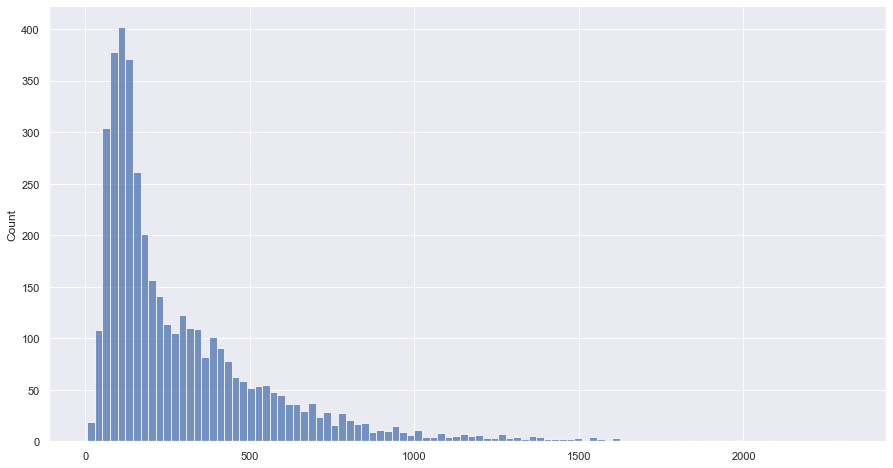

In [115]:
plt.figure(figsize=(15, 8))
sns.histplot(diffs, bins=100)

In [87]:
corpus_tokens_stem[diffs == 30]

array([list(['пациент', 'случайн', 'искажа', 'слов', 'врач', 'рожда', 'медицинск', 'миф', 'фот', 'тимоф', 'скор', 'стартова', 'сериа', 'бол', 'котор', 'вторник', 'вмест', 'врач', 'развенчива', 'миф', 'болезн', 'предлага', 'провер', 'может', 'отлич', 'настоя', 'медицинск', 'факт', 'вымысл', 'слух']),
       list(['президент', 'росс', 'владимир', 'путин', 'ма', 'подписа', 'документ', 'дает', 'возможн', 'молод', 'специалист', 'нужда', 'предприят', 'оборон', 'промышлен', 'комплекс', 'проход', 'альтернативн', 'служб', 'арм', 'мест', 'работ', 'отрыв', 'производств', 'оборон', 'завод', 'сформирова', 'называ', 'производствен', 'рот'])],
      dtype=object)

In [116]:
np.unique(corpus_tokens_stem).shape[0] / float(corpus_tokens_stem.shape[0])

0.990964590964591

In [122]:
stat = {}

tmp_corp, tmp_texts = [], []

for i, tokens in enumerate(log_progress(corpus_tokens_stem)):
    s = ' '.join(tokens)
    if stat.get(s, None) is None:
        stat[s] = True
        tmp_corp.append(tokens)
        tmp_texts.append(texts[i])
        
corpus_tokens_stem = tmp_corp
texts = tmp_texts
print(len(corpus_tokens_stem), len(texts))

4058 4058


In [123]:
corpus_tokens_stem = np.asarray(corpus_tokens_stem)
texts = np.asarray(texts)

print(len(corpus_tokens_stem), len(texts))

4058 4058


In [132]:
corpus_tokens_stem[:10]

array([list(['сильн', 'прибав', 'неблагополучн', 'водител', 'молодеж', 'таксист', 'коммерсант', 'фот', 'читател', 'январ', 'го', 'банк', 'росс', 'существен', 'измен', 'ставк', 'прич', 'ряд', 'категор', 'страховк', 'подорожа', 'станет', 'дешевл', 'детальн', 'изуч', 'постановлен', 'центробанк', 'замет', 'четк', 'тенденц', 'стал', 'накладн', 'ровн', 'автомобилист', 'котор', 'страхов', 'отказыва', 'продаж', 'полис', 'прошл', 'подробн', 'изменен', 'наш', 'материал', 'рассчитыва', 'страховщик', 'выбира', 'базов', 'тариф', 'указа', 'банк', 'росс', 'предел', 'умножа', 'коэффициент', 'учитыва', 'мощност', 'двигател', 'период', 'использован', 'машин', 'аварийн', 'водител', 'коэффициент', 'возраст', 'стаж', 'водител', 'территор', 'использован', 'срок', 'страхован', 'налич', 'груб', 'нарушен', 'последн', 'коэффициент', 'завис', 'штраф', 'гибдд', 'нарушен', 'прав', 'страхован', 'тарифн', 'коридор', 'расшир', 'диапазон', 'базов', 'ставк', 'очередн', 'увелич', 'начал', 'страховщик', 'выбира', 'коридо

In [124]:
diffs = np.asarray([len(tokens) for tokens in corpus_tokens_stem])
print(len(diffs))

4058


<AxesSubplot:ylabel='Count'>

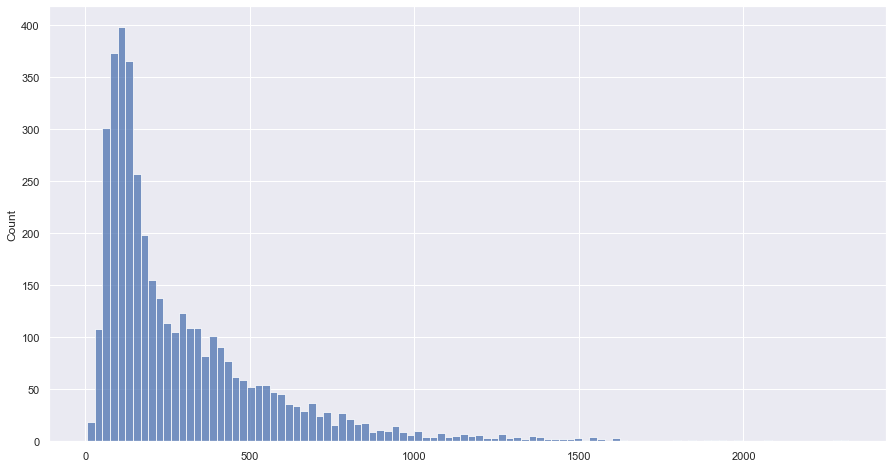

In [126]:
plt.figure(figsize=(15, 8))
sns.histplot(diffs, bins=100)

In [128]:
corpus_tokens_stem[diffs == 400]

array([list(['осен', 'ценник', 'переписа', 'марк', 'фот', 'арт', 'красн', 'рост', 'цен', 'автомоб', 'нача', 'весн', 'интенсифицирова', 'конц', 'автоваз', 'увеличива', 'стоимост', 'бестселлер', 'практическ', 'месяц', 'последн', 'прайс', 'измен', 'половин', 'ноябр', 'отста', 'конкурент', 'российск', 'автозавод', 'мен', 'ценник', 'вне', 'график', 'сто', 'нов', 'подержа', 'автомоб', 'наш', 'материал', 'автоваз', 'например', 'нынешн', 'корректировк', 'цен', 'шест', 'вероятн', 'последн', 'производител', 'прошл', 'год', 'меня', 'цен', 'мелк', 'порц', 'ограничива', 'четырьм', 'подход', 'ноябр', 'возросл', 'цен', 'рубл', 'сравнен', 'конц', 'прошл', 'сто', 'рубл', 'апрел', 'перв', 'волн', 'ослаблен', 'рубл', 'стоимост', 'подня', 'рубл', 'сам', 'прост', 'оценива', 'рубл', 'неполн', 'прибав', 'цен', 'рубл', 'фот', 'арт', 'красн', 'начальн', 'декабр', 'прошл', 'отдава', 'рубл', 'найт', 'дешевл', 'рубл', 'кстат', 'сумм', 'явля', 'минимальн', 'ценов', 'планк', 'нов', 'автомобил', 'росс', 'учет', 'ски

In [138]:
corpus_tokens_stem[diffs >= 10].shape

(4054,)

In [139]:
corp4learning = corpus_tokens_stem[diffs >= 10]
texts4learning = texts[diffs >= 10]

In [140]:
tmp_corp = []

for tokens in corp4learning:
    tmp_corp.append([t for t in tokens if len(t) > 2])
corp4learning = tmp_corp

**Словарь**

In [141]:
vocab = np.unique(np.concatenate(corp4learning).flatten()).tolist()
print(len(vocab))

33729


In [147]:
vocab[:10]

['абака',
 'абакан',
 'абакум',
 'абакумов',
 'аббревиатур',
 'абвер',
 'абдоминальн',
 'абдулкерим',
 'аберрац',
 'абзац']

In [148]:
vectorizer = CountVectorizer(max_features=5000, min_df=5, max_df=0.7)